# Analysis of Global Nucleosome Positioning in *Arabidopsis thaliana*
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: June 2, 2021 </br>
**Description**: Micrococcal nuclease digestion with deep sequencing (MNase-seq) is a molecular biology technique that measures nucleosome occupancy across the whole genome. After processing paired-end MNase-seq data using the workflow here: https://github.com/etc27/MNaseseq-workflow/blob/main/README.md, a table is generated that contains nucleosome profiles across different genomic regions. The following code loads metadata from the generation of nucleosome TSS metaprofiles (profiles showing average nucleosome occupancy relative to the Transcription Start Site of genes) and performs dimensionality reduction and clustering analysis in order to learn meaningful patterns in the data. In combination with RNA sequencing (RNA-seq) data, information about global gene expression is also included in the models below to provide more information about gene features for cluster assignment. This code analyzes merged biological replicates corresponding to the same genotype.

In [1]:
#Load required dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision.transforms as transforms

In [2]:
#Set path to save plot
save_path = "/Users/emmacorcoran/Documents/Jupyter Code/2021_05_24_MNase"

## Load and Clean Data
First, I load the data generated using deeptools and clean by removing empty columns, adding columns corresponding to gene names, and subsectioning data by sample. I also take a look at the metaprofiles by plotting the sum over all genes.

In [3]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_05_24/deeptools/"
filename = "mnase-merged-proteincoding.tab"
path_to_file = os.path.join(base_path, filename)
data_matrix = pd.read_csv(path_to_file, skiprows=2, sep='\t')

In [4]:
data_matrix.head()

,Col.mnase-fcnorm,Col.mnase-fcnorm.1,Col.mnase-fcnorm.2,Col.mnase-fcnorm.3,Col.mnase-fcnorm.4,Col.mnase-fcnorm.5,Col.mnase-fcnorm.6,Col.mnase-fcnorm.7,Col.mnase-fcnorm.8,Col.mnase-fcnorm.9,...,arid5.mnase-fcnorm.190,arid5.mnase-fcnorm.191,arid5.mnase-fcnorm.192,arid5.mnase-fcnorm.193,arid5.mnase-fcnorm.194,arid5.mnase-fcnorm.195,arid5.mnase-fcnorm.196,arid5.mnase-fcnorm.197,arid5.mnase-fcnorm.198,arid5.mnase-fcnorm.199
0,0.029120,0.05333,0.05087,0.06827,0.071100,0.075830,0.10630,0.08094,0.08169,0.05976,...,0.12060,0.12910,0.12590,0.06957,0.08162,0.064890,0.042150,0.036790,0.007526,0.003345
1,0.004917,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.02626,0.02776,0.02341,0.02157,0.01271,0.009533,0.010030,0.007024,0.003345,0.000502
2,0.029310,0.02515,0.02005,0.00851,0.007753,0.008131,0.02345,0.04955,0.05957,0.06014,...,0.03128,0.05452,0.06021,0.05987,0.03897,0.015720,0.005352,0.017060,0.025420,0.036630
3,0.030260,0.03669,0.06524,0.06694,0.060320,0.055220,0.03253,0.02647,0.02042,0.02572,...,0.05737,0.06673,0.06673,0.06222,0.02726,0.016890,0.015390,0.019070,0.019070,0.051850
4,0.057110,0.04368,0.02742,0.04463,0.054650,0.064670,0.06959,0.06240,0.05484,0.04047,...,0.01790,0.01656,0.01338,0.01171,0.00669,0.005519,0.008362,0.017900,0.036290,0.041480


In [6]:
#Matrix containing gene names corresponding to each row of data_matrix
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_05_24/deeptools/"
filename = "mnase-merged-proteincoding.bed"
path_to_file = os.path.join(base_path, filename)
sorted_genes = pd.read_csv(path_to_file, sep='\t')
#Make dataframe containing gene names and relabel gene naming convention to correspond with RNA-seq data
gene_names = sorted_genes['name'].copy()
gene_num = len(gene_names)
for i in range(gene_num):
    newname = gene_names[i]
    if newname[0:2] == 'AT':
        gene_names[i] = newname[0:-2]

In [7]:
#Make metadata matrix (has profile values and gene names)
metadata = data_matrix.copy()
metadata['gene name'] = gene_names

In [8]:
metadata.head()

,Col.mnase-fcnorm,Col.mnase-fcnorm.1,Col.mnase-fcnorm.2,Col.mnase-fcnorm.3,Col.mnase-fcnorm.4,Col.mnase-fcnorm.5,Col.mnase-fcnorm.6,Col.mnase-fcnorm.7,Col.mnase-fcnorm.8,Col.mnase-fcnorm.9,...,arid5.mnase-fcnorm.191,arid5.mnase-fcnorm.192,arid5.mnase-fcnorm.193,arid5.mnase-fcnorm.194,arid5.mnase-fcnorm.195,arid5.mnase-fcnorm.196,arid5.mnase-fcnorm.197,arid5.mnase-fcnorm.198,arid5.mnase-fcnorm.199,gene name
0,0.029120,0.05333,0.05087,0.06827,0.071100,0.075830,0.10630,0.08094,0.08169,0.05976,...,0.12910,0.12590,0.06957,0.08162,0.064890,0.042150,0.036790,0.007526,0.003345,AT1G01010
1,0.004917,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.02776,0.02341,0.02157,0.01271,0.009533,0.010030,0.007024,0.003345,0.000502,AT1G01020
2,0.029310,0.02515,0.02005,0.00851,0.007753,0.008131,0.02345,0.04955,0.05957,0.06014,...,0.05452,0.06021,0.05987,0.03897,0.015720,0.005352,0.017060,0.025420,0.036630,AT1G01030
3,0.030260,0.03669,0.06524,0.06694,0.060320,0.055220,0.03253,0.02647,0.02042,0.02572,...,0.06673,0.06673,0.06222,0.02726,0.016890,0.015390,0.019070,0.019070,0.051850,AT1G01040
4,0.057110,0.04368,0.02742,0.04463,0.054650,0.064670,0.06959,0.06240,0.05484,0.04047,...,0.01656,0.01338,0.01171,0.00669,0.005519,0.008362,0.017900,0.036290,0.041480,AT1G01050


## Plot sum of all genes

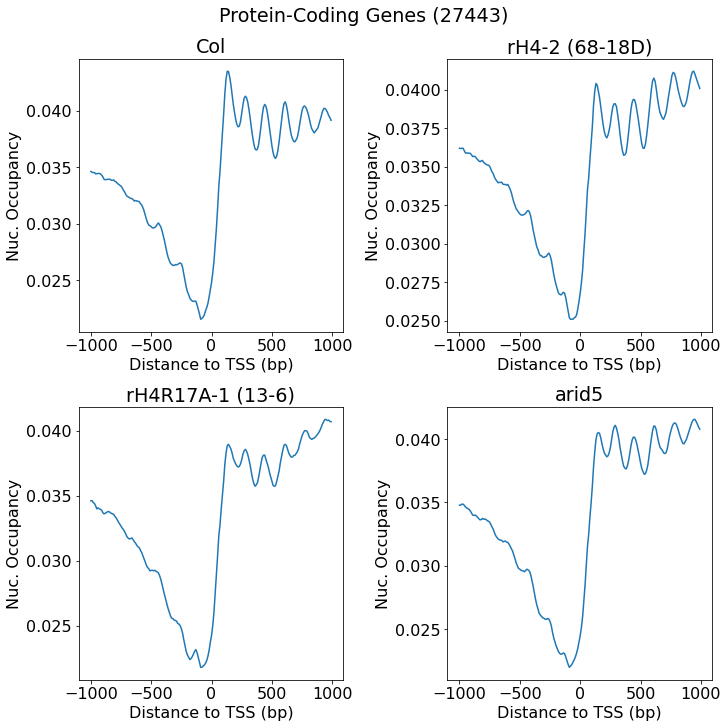

In [9]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#sum all rows
rowsum = data_matrix.sum(axis=0)/27443

#Split data by sample
Col_1_data = rowsum[0:200].tolist()
H4WT_2_data = rowsum[200:400].tolist()
R17A_1_data = rowsum[400:600].tolist()
arid5_data = rowsum[600:800].tolist()

#Plot data
plt.rcParams.update({'font.size': 16})
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.set_size_inches(10, 10)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col_1_data)
axs[0, 0].set_title('Col')

axs[0, 1].plot(x_vals, H4WT_2_data)
axs[0, 1].set_title('rH4-2 (68-18D)')

axs[1, 0].plot(x_vals, R17A_1_data)
axs[1, 0].set_title('rH4R17A-1 (13-6)')

axs[1, 1].plot(x_vals, arid5_data)
axs[1, 1].set_title('arid5')

fig.suptitle('Protein-Coding Genes (' + str(len(data_matrix)) + ")")
filename = "protein-coding_profiles/merged"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file)

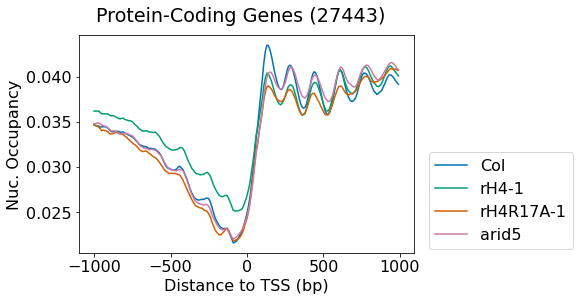

In [10]:
#Plot all data on same plot
plt.rcParams.update({'font.size': 16})
plt.style.use('seaborn-colorblind')
x_vals = np.arange(-1000,1000,10)
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('Nuc. Occupancy')
plt.plot(x_vals, Col_1_data, label='Col')
plt.plot(x_vals, H4WT_2_data, label='rH4-1')
plt.plot(x_vals, R17A_1_data, label='rH4R17A-1')
plt.plot(x_vals, arid5_data, label='arid5')
plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0))
plt.suptitle('Protein-Coding Genes (' + str(len(data_matrix)) + ")")
filename = "protein-coding_profiles/merged_oneplot"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file,bbox_inches='tight',dpi=500)

## Combine nucleosome positioning data with expression data from RNA-seq

In [11]:
# Subset data to only include protein coding genes (Chr1-5)
# Load protein coding gene annotation file
base_path = "/Users/emmacorcoran/Desktop/annotations"
filename = "proteincoding_1to5.txt"
path_to_file = os.path.join(base_path, filename)
proteincoding_list = pd.read_csv(path_to_file, sep='\t', header=None)
proteincoding_list.columns = ['gene name','classification']

In [12]:
# Merge metadata with protein coding list
metadata = pd.merge(metadata, proteincoding_list, on="gene name")
metadata.head()

,Col.mnase-fcnorm,Col.mnase-fcnorm.1,Col.mnase-fcnorm.2,Col.mnase-fcnorm.3,Col.mnase-fcnorm.4,Col.mnase-fcnorm.5,Col.mnase-fcnorm.6,Col.mnase-fcnorm.7,Col.mnase-fcnorm.8,Col.mnase-fcnorm.9,...,arid5.mnase-fcnorm.192,arid5.mnase-fcnorm.193,arid5.mnase-fcnorm.194,arid5.mnase-fcnorm.195,arid5.mnase-fcnorm.196,arid5.mnase-fcnorm.197,arid5.mnase-fcnorm.198,arid5.mnase-fcnorm.199,gene name,classification
0,0.029120,0.05333,0.05087,0.06827,0.071100,0.075830,0.10630,0.08094,0.08169,0.05976,...,0.12590,0.06957,0.08162,0.064890,0.042150,0.036790,0.007526,0.003345,AT1G01010,protein_coding
1,0.004917,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.02341,0.02157,0.01271,0.009533,0.010030,0.007024,0.003345,0.000502,AT1G01020,protein_coding
2,0.029310,0.02515,0.02005,0.00851,0.007753,0.008131,0.02345,0.04955,0.05957,0.06014,...,0.06021,0.05987,0.03897,0.015720,0.005352,0.017060,0.025420,0.036630,AT1G01030,protein_coding
3,0.030260,0.03669,0.06524,0.06694,0.060320,0.055220,0.03253,0.02647,0.02042,0.02572,...,0.06673,0.06222,0.02726,0.016890,0.015390,0.019070,0.019070,0.051850,AT1G01040,protein_coding
4,0.057110,0.04368,0.02742,0.04463,0.054650,0.064670,0.06959,0.06240,0.05484,0.04047,...,0.01338,0.01171,0.00669,0.005519,0.008362,0.017900,0.036290,0.041480,AT1G01050,protein_coding


In [13]:
#Load RNA-seq tpm expression data
def rnaseq_load(path):
    tpm_file = pd.read_csv(path, sep='\t', header=0)
    tpm_file.columns = ['gene name','rep1','rep2']
    tpm_file['avg'] = tpm_file[['rep1', 'rep2']].mean(axis=1)
    tpm_file = tpm_file.sort_values(by=['gene name'])
    return tpm_file

In [14]:
base_path_1 = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/ordered_tpm_avg/"
base_path_2 = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2021_05_21 RNA-seq/tpm/ordered_tpm_avg/"

#Load Col expression data
filename = "Col_ordered_tpm.txt"
path_to_file = os.path.join(base_path_1, filename)
Col_tpm = rnaseq_load(path_to_file)

#Load H4WT-2 (68-18D) expression data
filename = "68-18D_ordered_tpm.txt"
path_to_file = os.path.join(base_path_2, filename)
H4WT_2_tpm = rnaseq_load(path_to_file)

#Load H4R17A-1 (13-6) expression data
filename = "13-6_ordered_tpm.txt"
path_to_file = os.path.join(base_path_2, filename)
R17A_1_tpm = rnaseq_load(path_to_file)

#Load arid5 expression data
filename = "arid5_ordered_tpm.txt"
path_to_file = os.path.join(base_path_2, filename)
arid5_tpm = rnaseq_load(path_to_file)

In [15]:
#Merge metadata with tpm expression data and subset for one sample, plot expression groups
def rowsum_tpm(all_data, tpm_label):
    tpm_data = all_data.loc[all_data['expression category'] == tpm_label]
    tpm_data = tpm_data.iloc[:,0:200]
    nrow = tpm_data.shape[0]
    tpm_rowsum = np.array(tpm_data.sum(axis=0))/nrow
    return tpm_rowsum

In [16]:
def tpm_expression_4groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=2.5)
    print('Very high expression: ' + str(np.count_nonzero(high_tpm)))
    medhigh_tpm = ((subset_data['expression']>=0.5) & (subset_data['expression']<2.5))
    print('High expression: ' + str(np.count_nonzero(medhigh_tpm)))
    medlow_tpm = ((subset_data['expression']>0) & (subset_data['expression']<0.5))
    print('Low expression: ' + str(np.count_nonzero(medlow_tpm)))
    low_tpm = (subset_data['expression']==0)
    print('Very low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "very high"
    subset_data.loc[medhigh_tpm==True, ['expression category']] = "high"
    subset_data.loc[medlow_tpm==True, ['expression category']] = "low"
    subset_data.loc[low_tpm==True, ['expression category']] = "very low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "very high")
    medhigh_rowsum = rowsum_tpm(subset_data, "high")
    medlow_rowsum = rowsum_tpm(subset_data, "low")
    low_rowsum = rowsum_tpm(subset_data, "very low")
    
    #Produce nucleosome occupancy plots of tpm expression groups (labeled with number of genes)
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(15, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[3].plot(x_vals, high_rowsum, 'tab:red')
    axs[3].set_title('Very High (' + str(np.count_nonzero(high_tpm)) + ')')
    axs[2].plot(x_vals, medhigh_rowsum, 'tab:orange')
    axs[2].set_title("High (" + str(np.count_nonzero(medhigh_tpm)) + ')')
    axs[1].plot(x_vals, medlow_rowsum, 'tab:green')
    axs[1].set_title("Low (" + str(np.count_nonzero(medlow_tpm)) + ')')
    axs[0].plot(x_vals, low_rowsum, 'tab:blue')
    axs[0].set_title("Very Low (" + str(np.count_nonzero(low_tpm)) + ')')
    
    fig.suptitle(name)
    filename = "tpm_profiles_4groups/numbers_merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name)
    
    #Produce nucleosome occupancy plots of tpm expression groups (not labeled with number of genes)
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(15, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[3].plot(x_vals, high_rowsum, 'tab:red')
    axs[3].set_title('Very High')
    axs[2].plot(x_vals, medhigh_rowsum, 'tab:orange')
    axs[2].set_title("High")
    axs[1].plot(x_vals, medlow_rowsum, 'tab:green')
    axs[1].set_title("Low")
    axs[0].plot(x_vals, low_rowsum, 'tab:blue')
    axs[0].set_title("Very Low")
    
    fig.suptitle(name)
    filename = "tpm_profiles_4groups/merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name)
    
    return subset_data

In [17]:
def tpm_expression_2groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=0.02)
    print('High expression: ' + str(np.count_nonzero(high_tpm)))
    low_tpm = (subset_data['expression']<0.02)
    print('Low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "high"
    subset_data.loc[low_tpm==True, ['expression category']] = "low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "high")
    low_rowsum = rowsum_tpm(subset_data, "low")
    
    #Produce nucleosome occupancy plots of tpm expression groups (with number of genes)
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[1].plot(x_vals, high_rowsum, color='red')
    axs[1].set_title("High (" + str(np.count_nonzero(high_tpm)) + ')')
    axs[0].plot(x_vals, low_rowsum, color='blue')
    axs[0].set_title("Low (" + str(np.count_nonzero(low_tpm)) + ')')
    
    fig.suptitle(name)
    filename = "tpm_profiles_2groups/numbers_merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name)
    
    #Produce nucleosome occupancy plots of tpm expression groups
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[1].plot(x_vals, high_rowsum, color='red')
    axs[1].set_title("High")
    axs[0].plot(x_vals, low_rowsum, color='blue')
    axs[0].set_title("Low")
    
    fig.suptitle(name)
    filename = "tpm_profiles_2groups/merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name)
    
    return subset_data

Very high expression: 9303
High expression: 6314
Low expression: 5881
Very low expression: 5945
High expression: 20484
Low expression: 6959


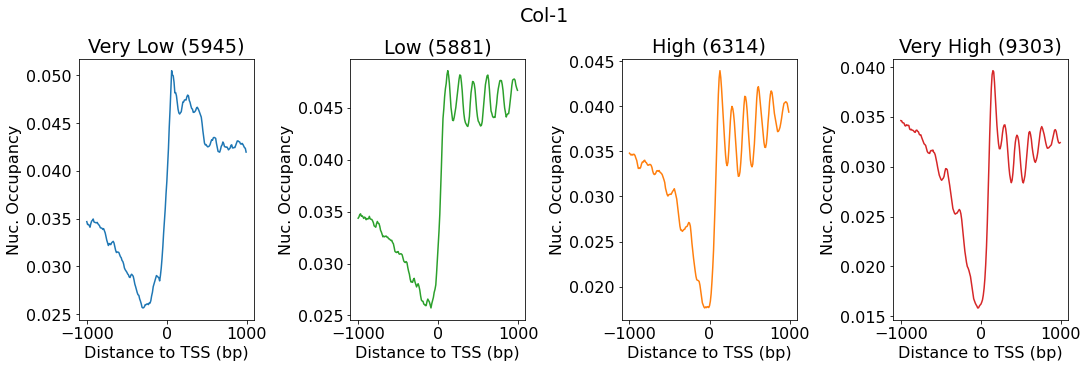

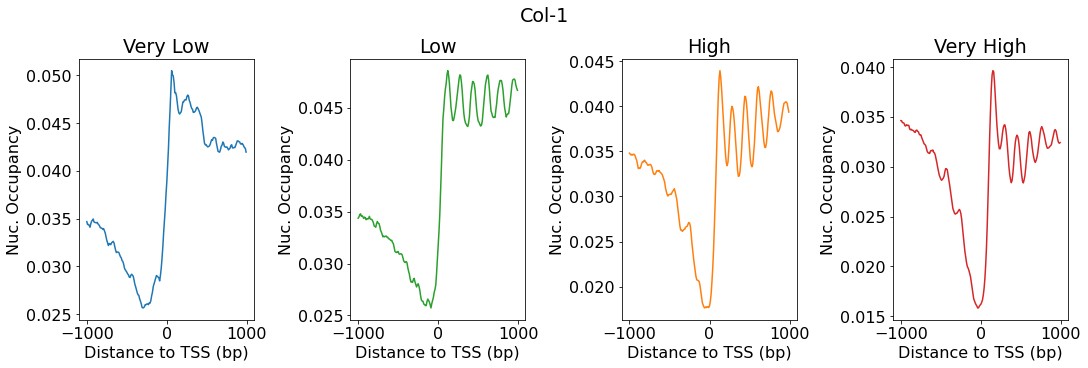

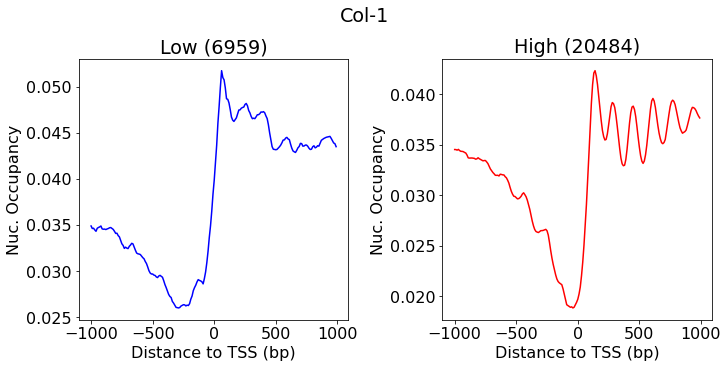

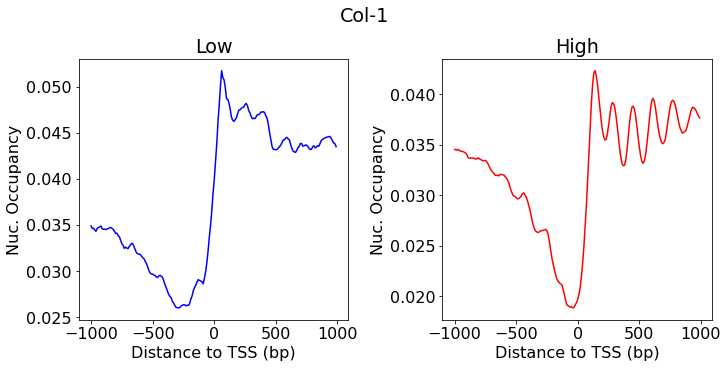

In [18]:
Col1_4subset = tpm_expression_4groups(metadata, Col_tpm, "Col.mnase-fcnorm","Col.mnase-fcnorm.199", "Col-1")
Col1_2subset = tpm_expression_2groups(metadata, Col_tpm, "Col.mnase-fcnorm","Col.mnase-fcnorm.199", "Col-1")

Very high expression: 7577
High expression: 6780
Low expression: 5846
Very low expression: 7240
High expression: 19199
Low expression: 8244


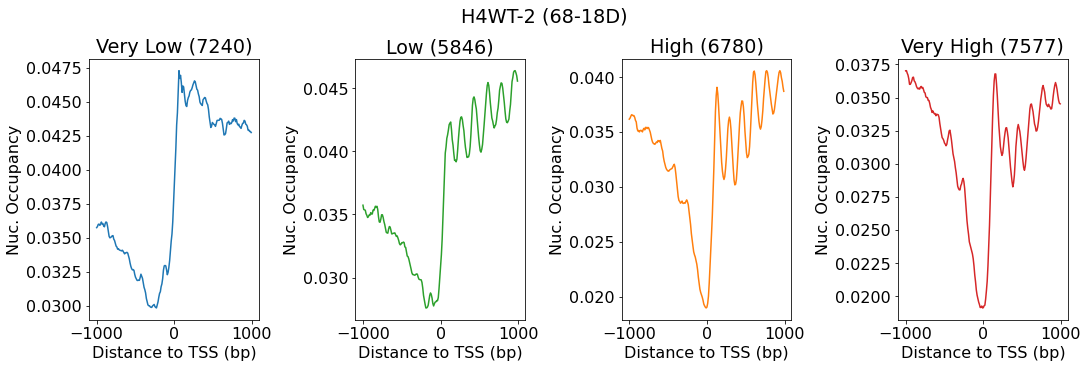

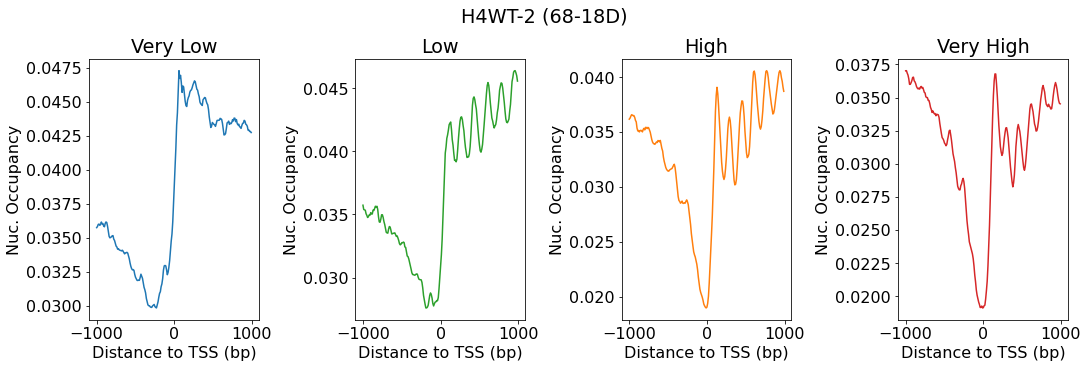

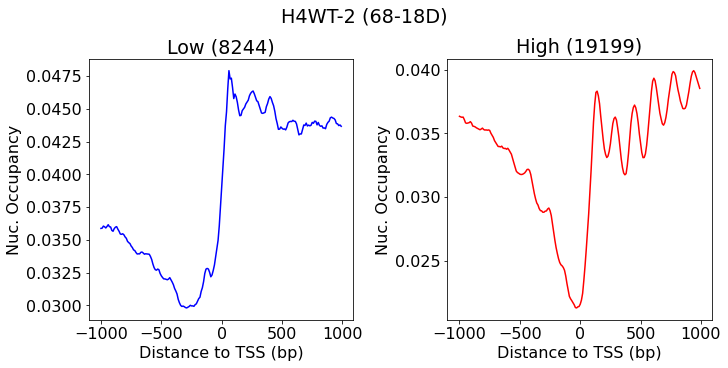

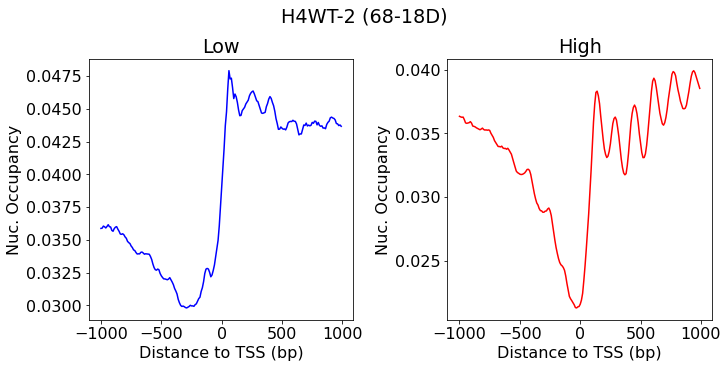

In [19]:
H4WT2_4subset = tpm_expression_4groups(metadata, H4WT_2_tpm, "68-18D.mnase-fcnorm","68-18D.mnase-fcnorm.199", "H4WT-2 (68-18D)")
H4WT2_2subset = tpm_expression_2groups(metadata, H4WT_2_tpm, "68-18D.mnase-fcnorm","68-18D.mnase-fcnorm.199", "H4WT-2 (68-18D)")

Very high expression: 8410
High expression: 6476
Low expression: 6337
Very low expression: 6220
High expression: 20027
Low expression: 7416


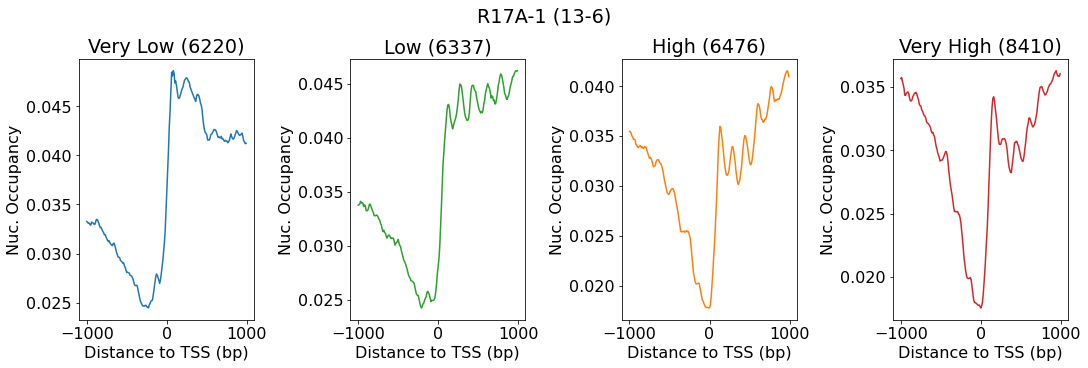

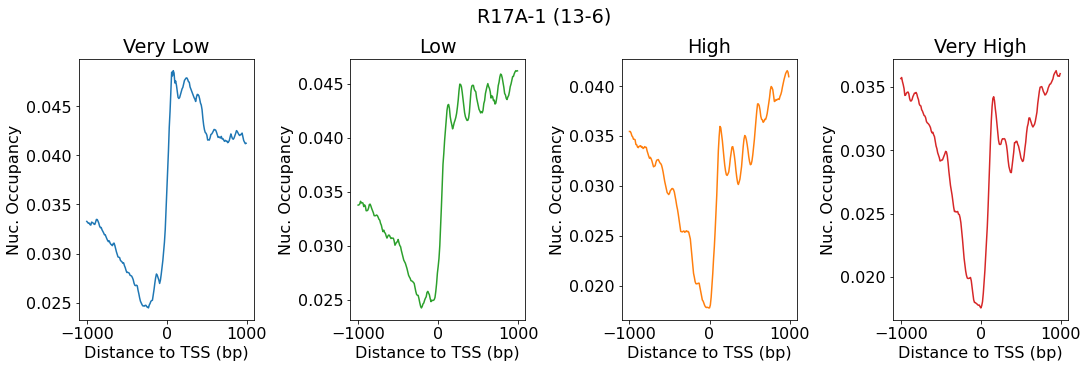

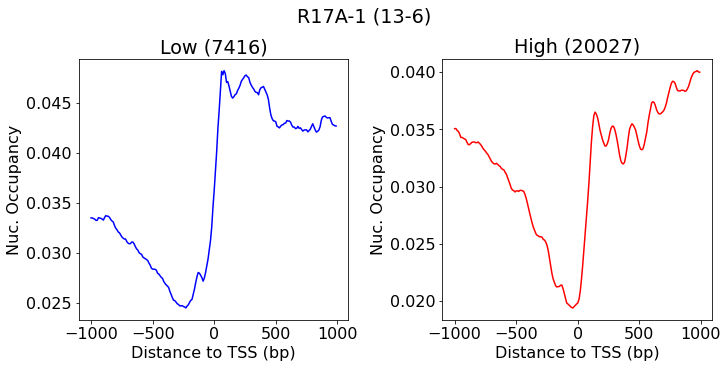

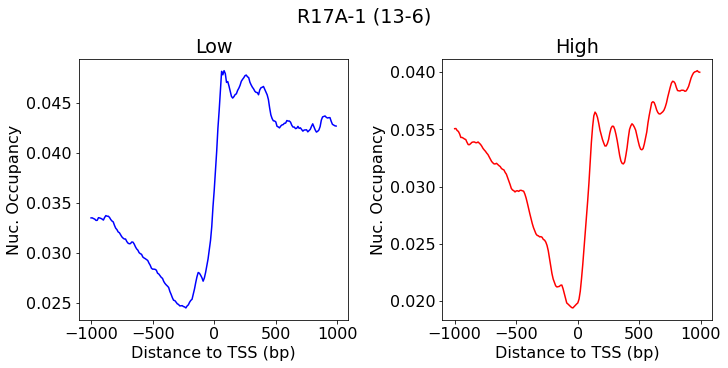

In [20]:
R17A1_4subset = tpm_expression_4groups(metadata, R17A_1_tpm, "13-6.mnase-fcnorm","13-6.mnase-fcnorm.199", "R17A-1 (13-6)")
R17A1_2subset = tpm_expression_2groups(metadata, R17A_1_tpm, "13-6.mnase-fcnorm","13-6.mnase-fcnorm.199", "R17A-1 (13-6)")

Very high expression: 9656
High expression: 5672
Low expression: 6150
Very low expression: 5965
High expression: 20118
Low expression: 7325


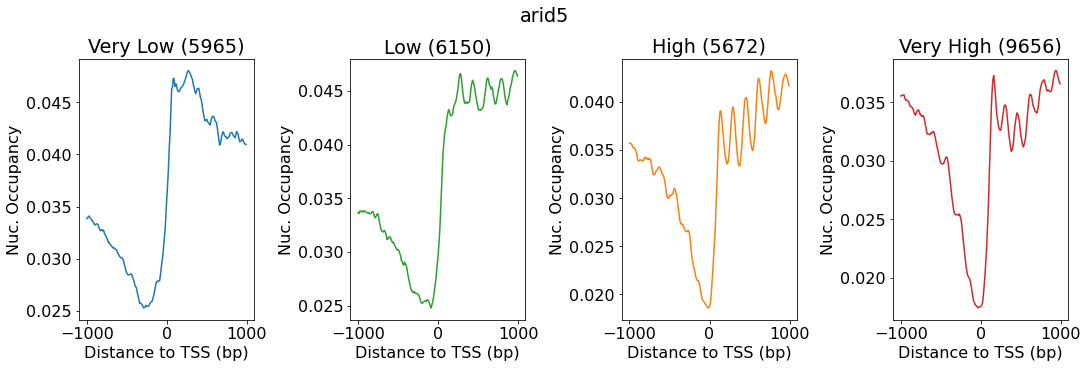

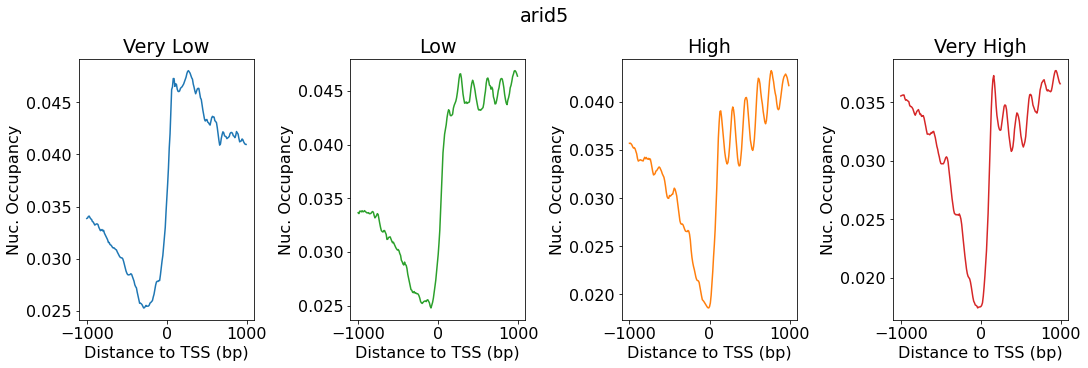

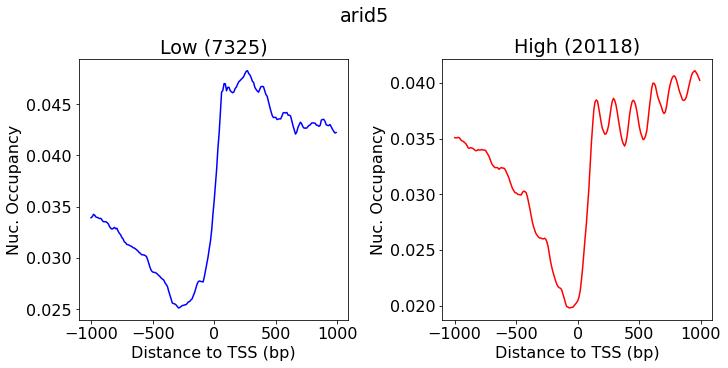

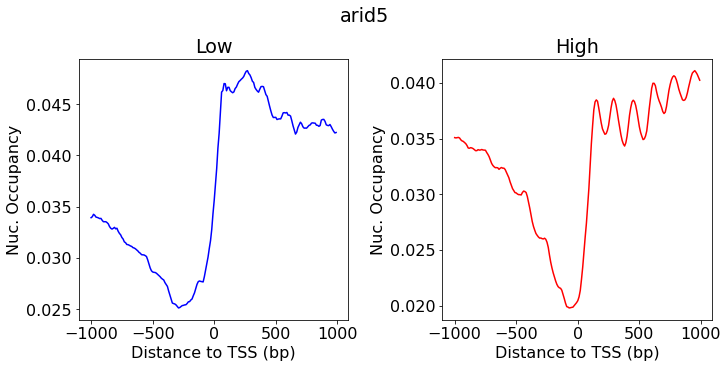

In [21]:
arid5_4subset = tpm_expression_4groups(metadata, arid5_tpm, "arid5.mnase-fcnorm","arid5.mnase-fcnorm.199", "arid5")
arid5_2subset = tpm_expression_2groups(metadata, arid5_tpm, "arid5.mnase-fcnorm","arid5.mnase-fcnorm.199", "arid5")

In [30]:
# Load DEG data
def deg_load(path, name):
    deg_file = pd.read_csv(path_to_file, sep='\t', header=None)
    deg_file.columns = [name]
    return deg_file

base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/H4_ISWI_RNA-seq 2col 2021_05_21/Up_and_Down"

#chr11/17 down-regulated genes
filename = "chr11chr17_downreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_downreg = deg_load(path_to_file, "gene name")
#chr11/17 up-regulated genes
filename = "chr11chr17_upreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_upreg = deg_load(path_to_file, "gene name")

#R17A-2 down-regulated genes
filename = "13.9_downreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_2_downreg = deg_load(path_to_file, "gene name")
#R17A-2 up-regulated genes
filename = "13.9_downreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_2_upreg = deg_load(path_to_file, "gene name")

#R17A-1 down-regulated genes
filename = "13.6_downreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_1_downreg = deg_load(path_to_file, "gene name")
#R17A-1 up-regulated genes
filename = "13.6_downreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_1_upreg = deg_load(path_to_file, "gene name")

#arid5 down-regulated genes
filename = "arid5_downreg.txt"
path_to_file = os.path.join(base_path, filename)
arid5_downreg = deg_load(path_to_file, "gene name")
#arid5 up-regulated genes
filename = "arid5_upreg.txt"
path_to_file = os.path.join(base_path, filename)
arid5_upreg = deg_load(path_to_file, "gene name")

In [31]:
def merge_upanddown(metadata, downreg, upreg):
    downreg_subset = pd.merge(metadata, downreg, on="gene name")
    upreg_subset = pd.merge(metadata, upreg, on="gene name")
    upreg_subset['DEG'] = "up"
    downreg_subset['DEG'] = "down"
    deg_subset = downreg_subset.append(upreg_subset)
    return(deg_subset)

In [32]:
#Merge metadata with DEG data
chr_deg_subset = merge_upanddown(metadata, chr_downreg, chr_upreg)
R17A_1_deg_subset = merge_upanddown(metadata, R17A_1_downreg, R17A_1_upreg)
arid5_deg_subset = merge_upanddown(metadata, arid5_downreg, arid5_upreg)
R17A_2_deg_subset = merge_upanddown(metadata, R17A_2_downreg, R17A_2_upreg)

In [33]:
def plot_gene_group(all_data, name, deg=True):
    #Merge metadata with tpm expression data and subset for one sample
    if deg==True:
        subset_data = all_data.drop(['gene name', 'classification', 'DEG'],axis=1)
    else:
        subset_data = all_data.drop(['gene name', 'classification'],axis=1)
    #Sum rows
    nrow = all_data.shape[0]
    rowsum = np.array(subset_data.sum(axis=0))/nrow

    #Split data by sample
    Col_1_data = rowsum[0:200].tolist()
    H4WT_2_data = rowsum[200:400].tolist()
    R17A_1_data = rowsum[400:600].tolist()
    arid5_data = rowsum[600:800].tolist()
    
    #Plot data
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(10, 10)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[0, 0].plot(x_vals, Col_1_data)
    axs[0, 0].set_title('Col-1')

    axs[0, 1].plot(x_vals, H4WT_2_data)
    axs[0, 1].set_title('rH4-2 (68-18D)')

    axs[1, 0].plot(x_vals, R17A_1_data)
    axs[1, 0].set_title('rH4R17A-1 (13-6)')

    axs[1, 1].plot(x_vals, arid5_data)
    axs[1, 1].set_title('arid5')
    
    fig.suptitle(name + " (" + str(nrow) + ")")
    filename = "DEG_plots/merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name)

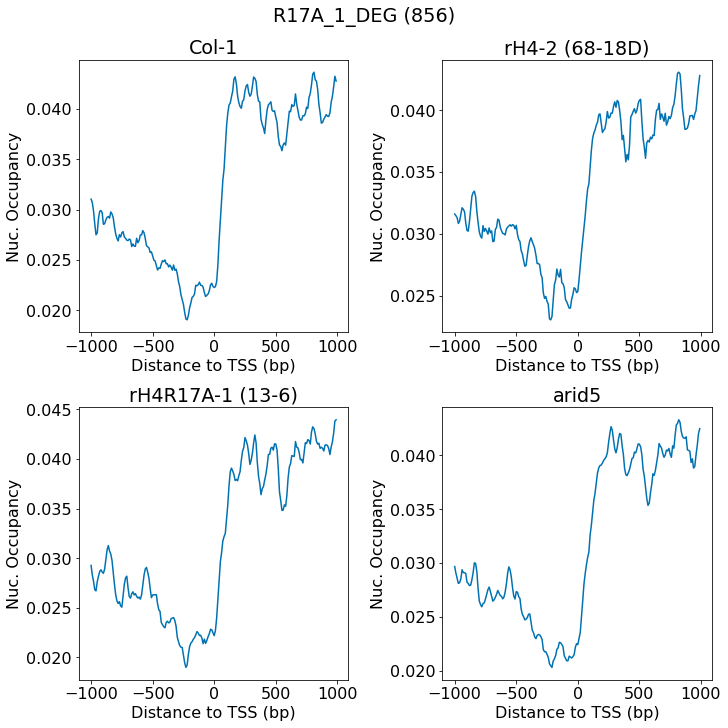

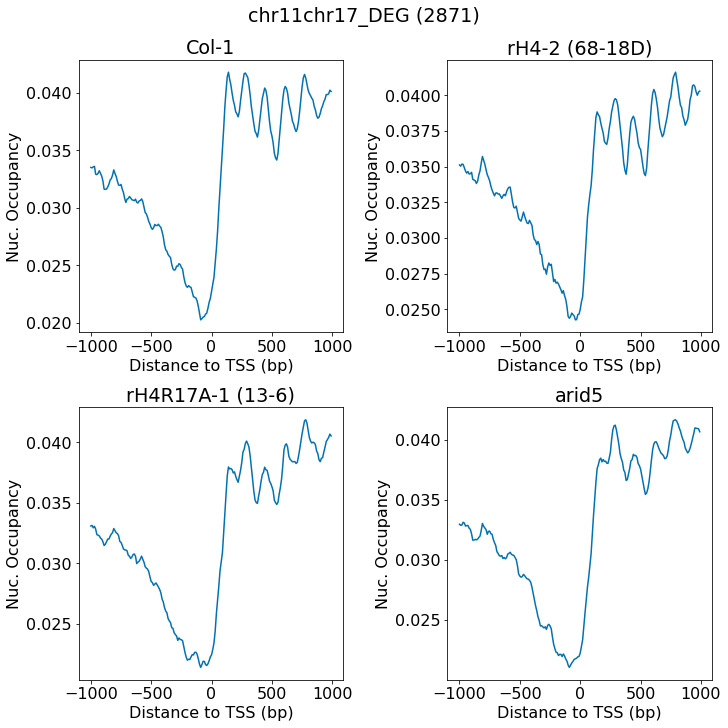

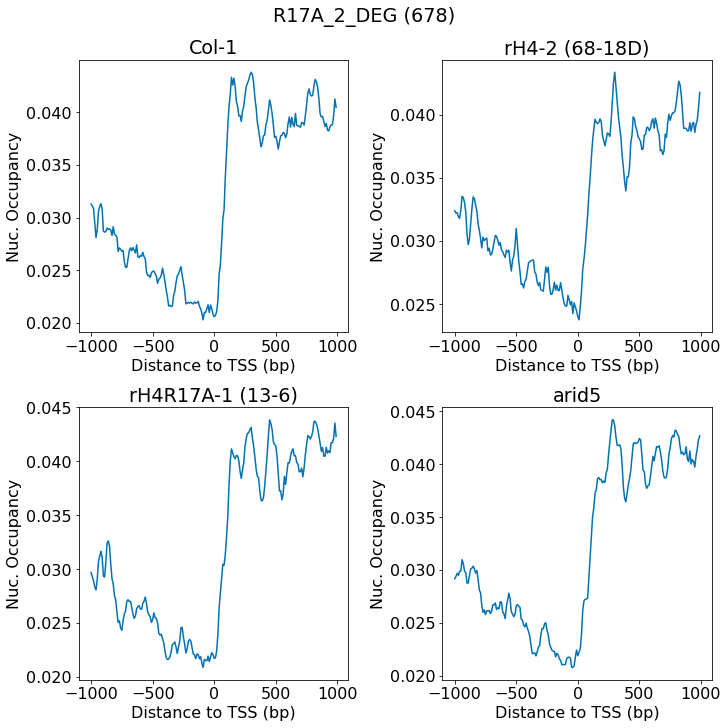

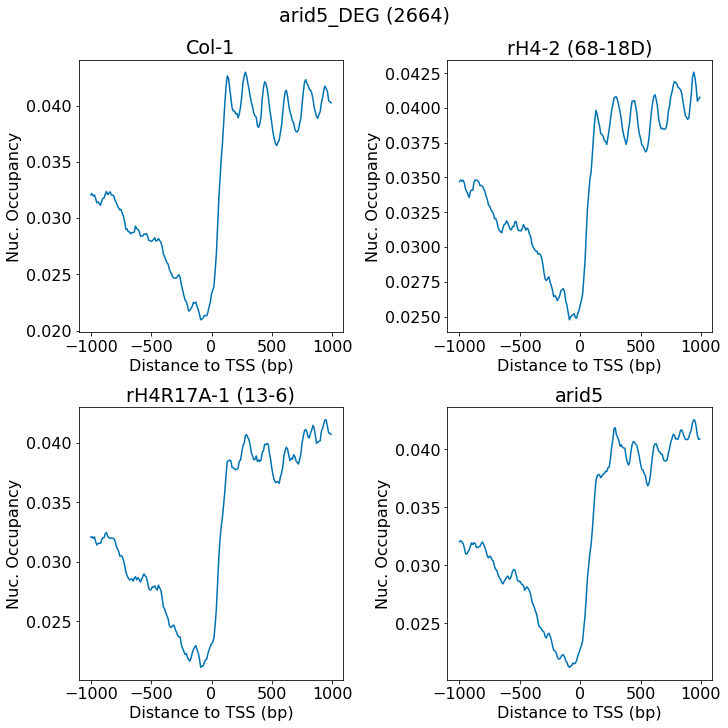

In [35]:
plot_gene_group(R17A_1_deg_subset, "R17A_1_DEG")
plot_gene_group(chr_deg_subset, "chr11chr17_DEG")
plot_gene_group(R17A_2_deg_subset, "R17A_2_DEG")
plot_gene_group(arid5_deg_subset, "arid5_DEG")

In [36]:
#Merge metadata with DEG data to find genes with no expression changes in chr11/17 mutant
merged = pd.merge(metadata, chr_deg_subset['gene name'], on="gene name", how="outer", indicator=True)
chr_nonaffected = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

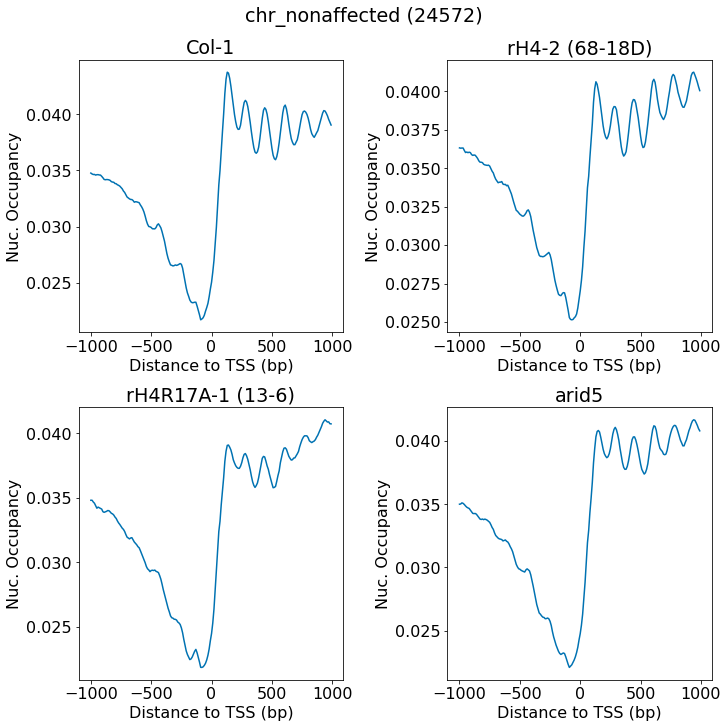

In [37]:
#Plot data
plot_gene_group(chr_nonaffected, "chr_nonaffected", deg=False)

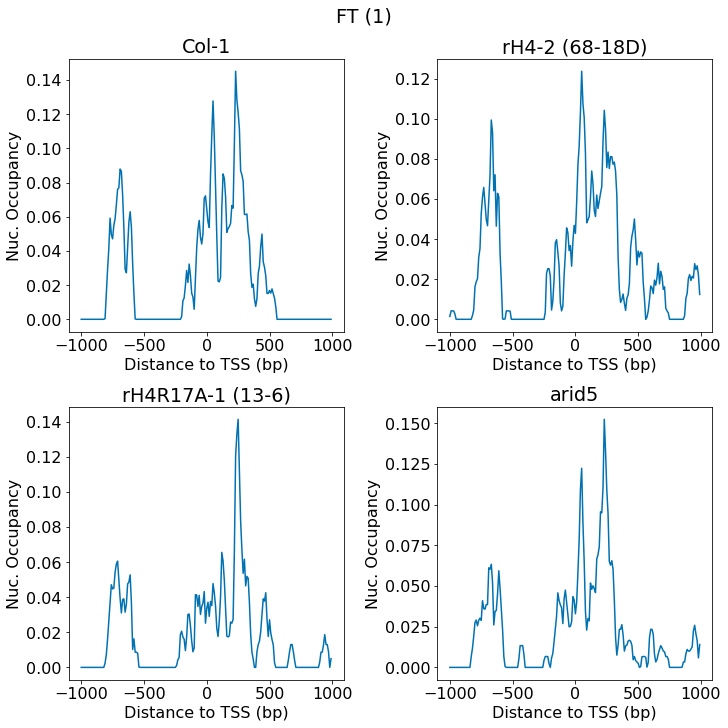

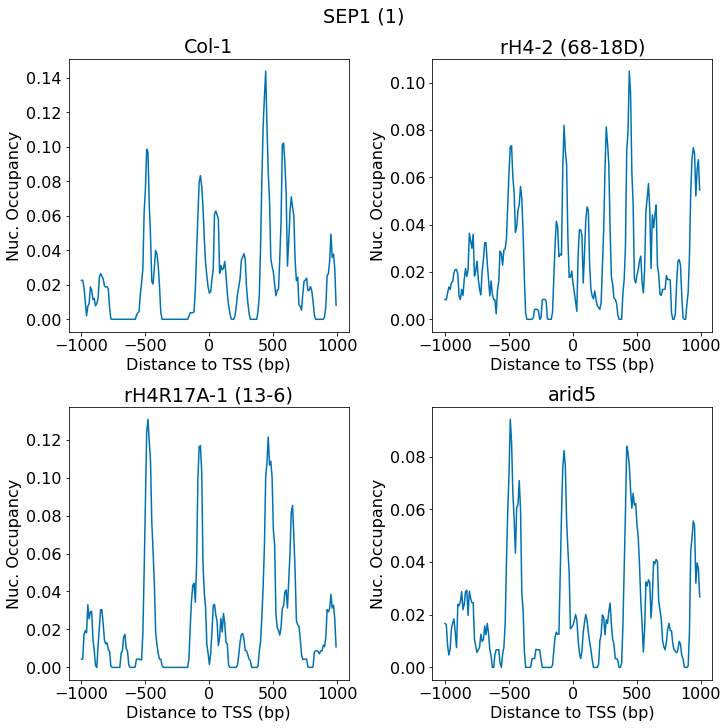

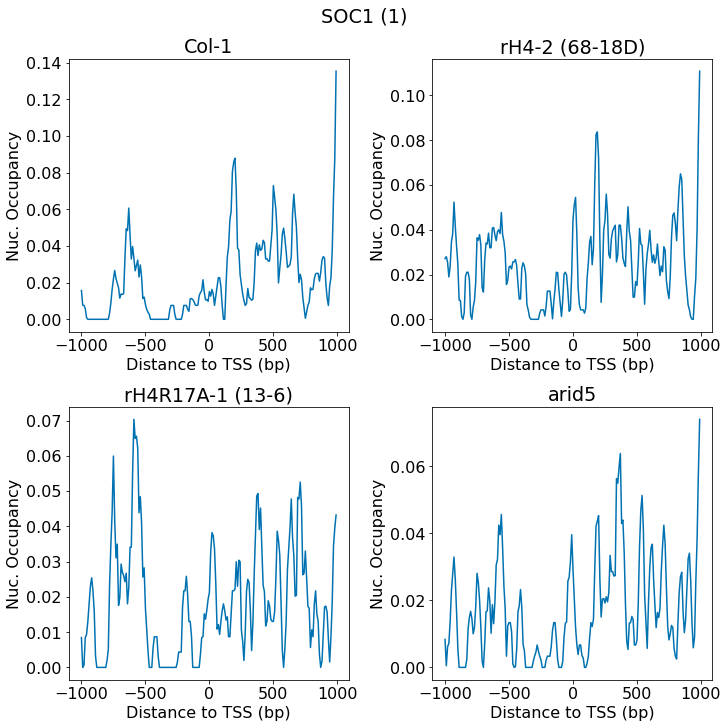

In [38]:
plot_gene_group(metadata.loc[metadata['gene name'] == 'AT1G65480'], "FT", deg=False)
plot_gene_group(metadata.loc[metadata['gene name'] == 'AT5G15800'], "SEP1", deg=False)
plot_gene_group(metadata.loc[metadata['gene name'] == 'AT2G45660'], "SOC1", deg=False)

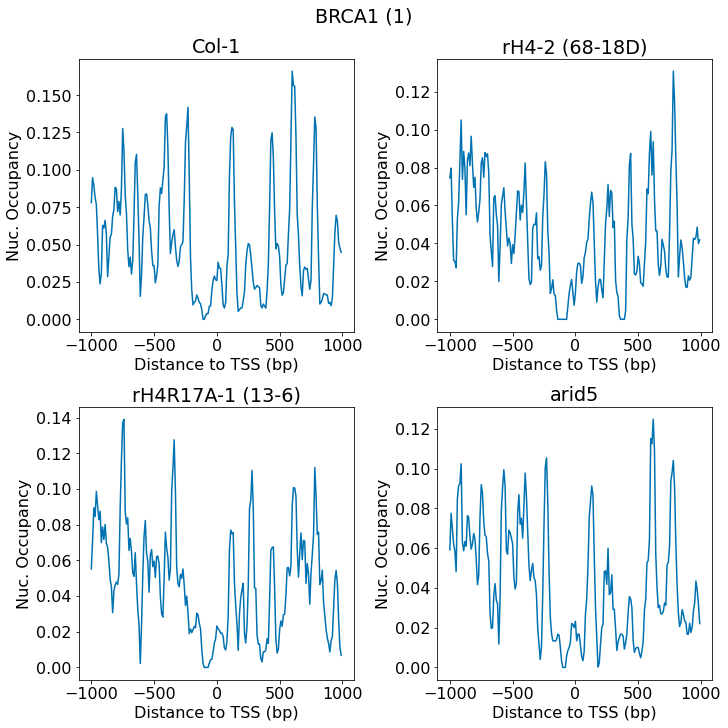

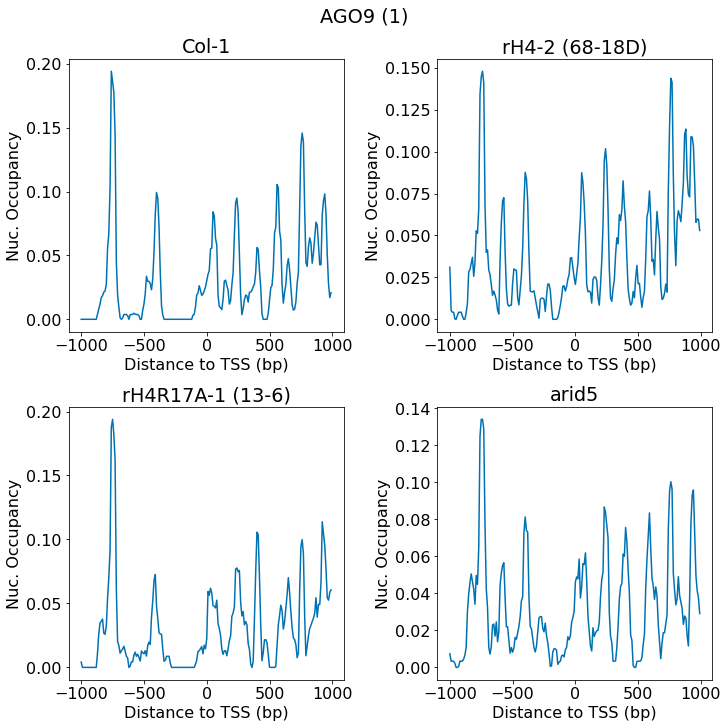

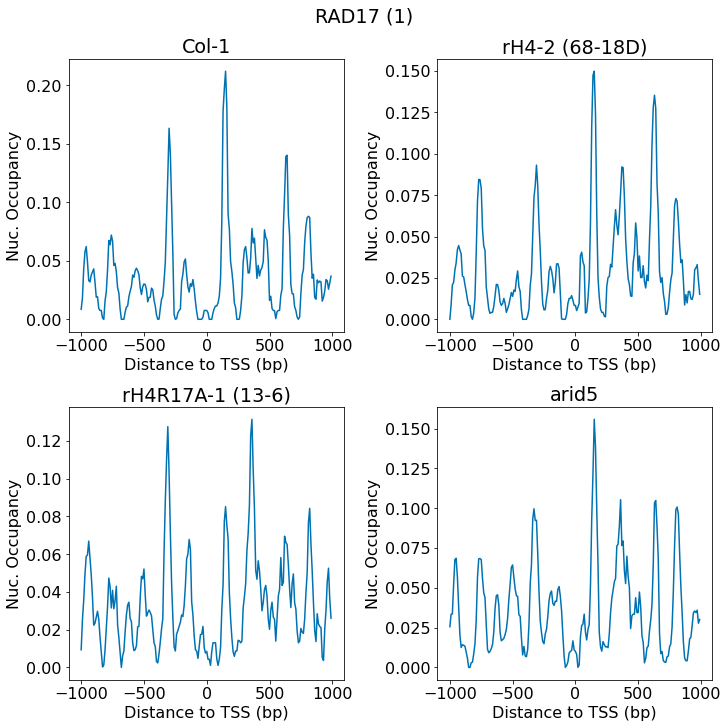

In [39]:
plot_gene_group(metadata.loc[metadata['gene name'] == 'AT4G21070'], "BRCA1", deg=False)
plot_gene_group(metadata.loc[metadata['gene name'] == 'AT5G21150'], "AGO9", deg=False)
plot_gene_group(metadata.loc[metadata['gene name'] == 'AT5G66130'], "RAD17", deg=False)